# FAKE NEWS DETECTION
In this projects, the aim is to create an algorithm that fact-checks claims and provides a truth rating for each. Claims are rated as TRUE, PARTLY TRUE or FALSE.

**Import Inital Libraries**

In [1]:
# General imports
import pandas as pd
import string
import numpy as np
import pandas as pd
import sklearn.feature_extraction as skprep
from sklearn.metrics import roc_curve, auc
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import random
import codecs

from collections import Counter
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud

import html
import re
from scipy import stats

!pip install nltk
import nltk
from nltk.tokenize import RegexpTokenizer


random.seed(20190124)

     |████████████████████████████████| 368kB 23.8MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 27.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [2]:
raw_data_df =pd.read_json('train.json')
with open('stop_words.txt','r') as f:
    stop_words = f.read().split('\n')

## Data Cleaning

In [3]:
raw_data_df.head(10)

,claim,claimant,date,label,related_articles,id
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,"[122094, 122580, 130685, 134765]",0
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,2,"[106868, 127320, 128060]",1
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,1,"[132130, 132132, 149722]",4
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,2,"[123254, 123418, 127464]",5
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6
5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,2,"[8284, 3768, 20091, 82368, 73148, 4493]",7
6,The poorest counties in the U.S. are in Appala...,Jim Webb,2014-11-19,1,"[70709, 70708]",8
7,Koch Industries paid the legal fees of George ...,,2013-07-18,0,"[120591, 120592, 127866, 129483]",9
8,"""Minnesota, Michigan, Iowa already have 70 mph...",Robin Vos,2013-08-22,1,"[69547, 80095, 7994, 81116, 77621]",11
9,"""FBI Uniform Crime Report for 2016 shows more ...",Nick Schroer,2017-10-17,1,"[72012, 26005, 43481, 55671]",12


In [4]:
raw_data_df.shape

(15555, 6)

In [5]:
# Number of different claimants
raw_data_df['claimant'].nunique()

3105

In [6]:
raw_data_df.iloc[9]['claim']

'"FBI Uniform Crime Report for 2016 shows more than four times as many people were stabbed to death than were killed with rifles of any kind."'

In [7]:
raw_data_df.iloc[:,2]

0       2017-07-17
1       2018-03-17
2       2018-07-18
3       2019-02-04
4       2016-03-22
           ...    
15550   2009-02-25
15551   2017-06-06
15552   2009-04-23
15553   2018-05-14
15554   2016-12-23
Name: date, Length: 15555, dtype: datetime64[ns]

In [8]:
# breakdown of claimants
col_a = raw_data_df['claimant'].value_counts(normalize=True)
col_b = raw_data_df['claimant'].value_counts()

claimnant_dsn = pd.DataFrame({'Count': col_a, 'Percentage': col_b})
claimnant_dsn

,Count,Percentage
,0.318997,4962
Donald Trump,0.079267,1233
Bloggers,0.023915,372
Barack Obama,0.015043,234
Hillary Clinton,0.014143,220
...,...,...
Center for Western Priorities,0.000064,1
Talal Naji,0.000064,1
Peter Navarro,0.000064,1
Ufconly,0.000064,1


In [9]:
claimant_missing_values = raw_data_df['claimant'].isnull().sum()
claimant_missing_values

0

In [10]:
#Change non-disclosed claimant to "Unknown"
raw_data_df['claimant'] = raw_data_df['claimant'].replace('', 'Unknown')

In [11]:
col_a = raw_data_df['claimant'].value_counts(normalize=True)
col_b = raw_data_df['claimant'].value_counts()

claimnant_dsn = pd.DataFrame({'Count': col_a, 'Percentage': col_b})
claimnant_dsn.head(10)

,Count,Percentage
Unknown,0.319254,4966
Donald Trump,0.079267,1233
Bloggers,0.023915,372
Barack Obama,0.015043,234
Hillary Clinton,0.014143,220
Viral image,0.008165,127
Facebook posts,0.006943,108
Ted Cruz,0.006815,106
Various websites,0.006815,106
Bernie Sanders,0.006493,101


## We Create a "DataCleaner" function that makes the following adjustments:
* All html tags and attributes (i.e., /<[^>]+>/) are removed.
* Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
* All URLs are removed.
* All characters in the text are in lowercase.
* All stop words are removed. Be clear in what you consider as a stop word.
* If a tweet is empty after pre-processing, it should be preserved as such.

In [12]:
class DataCleaner(object):
    def __init__(self,stop_words=[""], remove_steps = []):
        super().__init__()
        self.hashtags = str()
        self.remove_steps = remove_steps
        self.stop_words = stop_words 
        self.procedures = [getattr(self,procedure) for procedure in \
                        [step for step in sorted(dir(self)) if step.startswith("step_")]]
        # remove some procedures according to users' needs
        for i in sorted(self.remove_steps,reverse=True):
                self.procedures.pop(i-1)

    #use reduce to sequentially clean the raw data, equivelent to funcN(...func2(func1(data)))
    def clean(self, data):
            return reduce(lambda data,func:func(data),[data]+self.procedures), self.hashtags

    # Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    def step_01_to_ascii(self, data):
        return html.unescape(data)

    # Remove html tags and attributes in form of <...>
    def step_02_remove_html_tag(self, data):
        return re.sub(r"\s*<.*?>",'', data)

    # Remove url in form of (http or https://)address.domain(/file)
    def step_03_remove_url(self, data):
        return re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',data)

    # Change all characters in the text to lowercase.
    def step_04_to_lower(self, data):
        return data.lower()

    # Collect @ tag message
    def step_05_hashtag_collection(self,data):
        self.hashtags = ' '.join(re.findall(r'(?<=@)[^\s]+\s?',data))
        return re.sub(r'@.*?\s','',data)

    # Tokenize the word stream
    def step_06_tokenization(self,data):
        tokenizer = RegexpTokenizer(r'\w+')
        words_list = tokenizer.tokenize(data)
        return ' '.join(words_list)

    # Remove stop words
    def step_07_remove_stop_words(self,data):
        words = data.split()
        new_data = [word for word in words if word not in self.stop_words]
        return ' '.join(new_data) # clean up empty charactor

    # Remove non alphanumeric characters except space
    def step_08_remove_nonAlphaNumerical(self,data):
        return re.sub(r'[^\s\w]+','',data)

In [13]:
#Apply our data cleaner to our text
geneCleaner = DataCleaner(stop_words,[5])
raw_data_df['cleaned_text'],_ = np.vectorize(geneCleaner.clean)(raw_data_df['claim'])
raw_data_df.head(3)

,claim,claimant,date,label,related_articles,id,cleaned_text
0,A line from George Orwell's novel 1984 predict...,Unknown,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,george orwell novel 1984 predicts power smartp...
1,Maine legislature candidate Leslie Gibson insu...,Unknown,2018-03-17,2,"[106868, 127320, 128060]",1,maine legislature candidate leslie gibson insu...
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,2018-07-18,1,"[132130, 132132, 149722]",4,17 year girl named alyssa carson trained nasa ...


In [14]:
#create variable for the number of references
raw_data_df['Num_refs'] = raw_data_df['related_articles'].apply(len)
raw_data_df.head()

,claim,claimant,date,label,related_articles,id,cleaned_text,Num_refs
0,A line from George Orwell's novel 1984 predict...,Unknown,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,george orwell novel 1984 predicts power smartp...,4
1,Maine legislature candidate Leslie Gibson insu...,Unknown,2018-03-17,2,"[106868, 127320, 128060]",1,maine legislature candidate leslie gibson insu...,3
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,2018-07-18,1,"[132130, 132132, 149722]",4,17 year girl named alyssa carson trained nasa ...,3
3,In 1988 author Roald Dahl penned an open lette...,Unknown,2019-02-04,2,"[123254, 123418, 127464]",5,1988 author roald dahl penned open letter urgi...,3
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,fighting terrorism thing work based lots empir...,6


In [15]:
#Obtain year claim is made
raw_data_df['year'] = pd.DatetimeIndex(raw_data_df['date']).year
raw_data_df.head()

,claim,claimant,date,label,related_articles,id,cleaned_text,Num_refs,year
0,A line from George Orwell's novel 1984 predict...,Unknown,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,george orwell novel 1984 predicts power smartp...,4,2017
1,Maine legislature candidate Leslie Gibson insu...,Unknown,2018-03-17,2,"[106868, 127320, 128060]",1,maine legislature candidate leslie gibson insu...,3,2018
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,2018-07-18,1,"[132130, 132132, 149722]",4,17 year girl named alyssa carson trained nasa ...,3,2018
3,In 1988 author Roald Dahl penned an open lette...,Unknown,2019-02-04,2,"[123254, 123418, 127464]",5,1988 author roald dahl penned open letter urgi...,3,2019
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,fighting terrorism thing work based lots empir...,6,2016


In [16]:
raw_data_df['year'].value_counts(normalize=True)

2018    0.240244
2017    0.198779
2016    0.182128
2019    0.100675
2015    0.066281
2014    0.065509
2013    0.049630
2010    0.023401
2011    0.019672
2008    0.017615
2012    0.017358
2009    0.014272
2007    0.004243
2004    0.000064
1986    0.000064
2000    0.000064
Name: year, dtype: float64

In [17]:
#US Election year: US presidential and congressional
raw_data_df['election'] =raw_data_df['year'].apply(lambda x: 'True' if (x - 2012)%4 == 0 or (x - 2012)%4 == 2 else 'False')
raw_data_df.head()

,claim,claimant,date,label,related_articles,id,cleaned_text,Num_refs,year,election
0,A line from George Orwell's novel 1984 predict...,Unknown,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,george orwell novel 1984 predicts power smartp...,4,2017,False
1,Maine legislature candidate Leslie Gibson insu...,Unknown,2018-03-17,2,"[106868, 127320, 128060]",1,maine legislature candidate leslie gibson insu...,3,2018,True
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,2018-07-18,1,"[132130, 132132, 149722]",4,17 year girl named alyssa carson trained nasa ...,3,2018,True
3,In 1988 author Roald Dahl penned an open lette...,Unknown,2019-02-04,2,"[123254, 123418, 127464]",5,1988 author roald dahl penned open letter urgi...,3,2019,False
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,fighting terrorism thing work based lots empir...,6,2016,True


In [18]:
#clean dataframe
df = raw_data_df

# Visualization and Exploratory analysis

### Distribution of truth labels: all data

In [19]:
truth_labels = ['0: False', '1: Partially True', "2: True"]

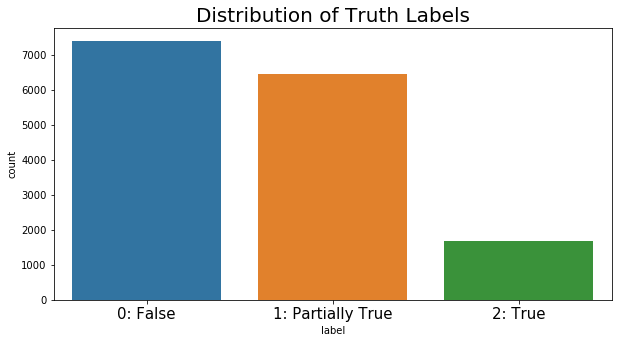

In [20]:
fig, (ax1) = plt.subplots(1, figsize=(10,5))
plt.title('Distribution of Truth Labels', fontsize = 20)
sns.countplot(x='label', data=df, ax=ax1)
plt.xticks([0,1,2], truth_labels, fontsize= 15)
plt.show()

In [21]:
a1 = df['label'].value_counts(normalize=True)
a2 = df['label'].value_counts()

dsn_all = pd.DataFrame({'Count': a2, 'Percentage': a1})
dsn_all.index = truth_labels
dsn_all

,Count,Percentage
0: False,7408,0.476246
1: Partially True,6451,0.414722
2: True,1696,0.109032


In [22]:
def get_data_Claimant(claim):
  d1 = df[df['claimant'] == claim]['label'].value_counts(normalize=True)
  d2 = df[df['claimant'] == claim]['label'].value_counts()

  dsn = pd.DataFrame({'Count': d2, 'Percentage': d1})
  dsn.index = truth_labels
  return(dsn)
  

In [23]:
def plot_Claimant(claim):
  fig, (ax1) = plt.subplots(1, figsize=(10,5))
  plt.title('Distribution of Truth Labels when Claimant is ' + claim, fontsize = 20)
  sns.countplot(x='label', data=df[df['claimant'] == claim], ax=ax1)
  plt.xticks([0,1,2], truth_labels, fontsize = 15)
  plt.xlim(-.5,2.5)
  plt.show()

### Distribution of truth labels: Unknown Claimant

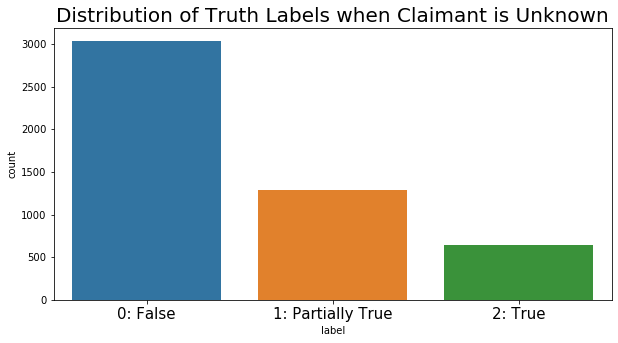

In [24]:
plot_Claimant("Unknown")

In [25]:
dsn_unknown = get_data_Claimant("Unknown")
dsn_unknown

,Count,Percentage
0: False,3035,0.611156
1: Partially True,1289,0.259565
2: True,642,0.129279


### Distribution of truth labels: Donald Trump

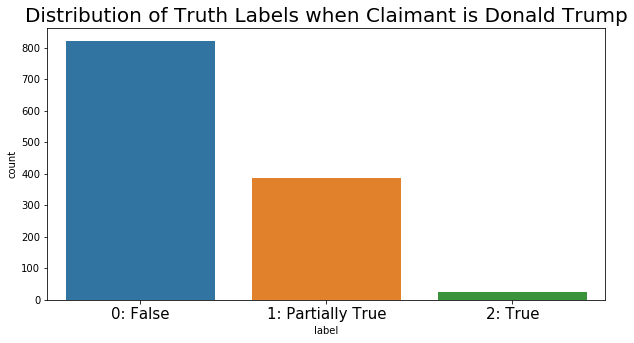

In [26]:
plot_Claimant("Donald Trump")

In [27]:
dsn_trump = get_data_Claimant("Donald Trump")
dsn_trump

,Count,Percentage
0: False,821,0.665856
1: Partially True,387,0.313869
2: True,25,0.020276


### Distribution of truth labels: Bloggers

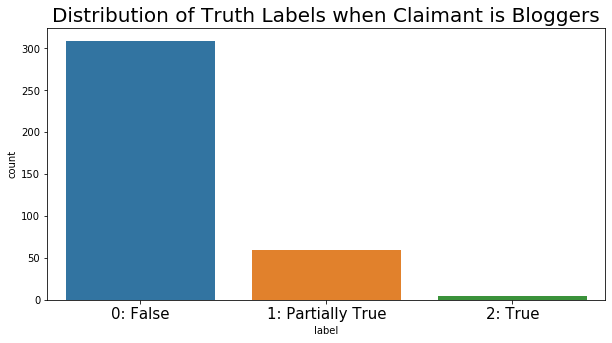

In [28]:
plot_Claimant("Bloggers")

In [29]:
dsn_bloggers = get_data_Claimant("Bloggers")
dsn_bloggers

,Count,Percentage
0: False,309,0.830645
1: Partially True,59,0.158602
2: True,4,0.010753


### Distribution of truth labels: Barack Obama

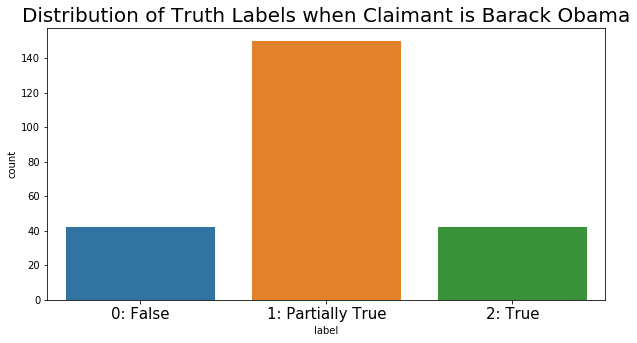

In [30]:
plot_Claimant("Barack Obama")

In [31]:
def get_data_Claimant_OC(claim):
  d1 = df[df['claimant'] == claim]['label'].value_counts(normalize=True)
  d2 = df[df['claimant'] == claim]['label'].value_counts()

  dsn = pd.DataFrame({'Count': d2, 'Percentage': d1})
  dsn.index = ['1: Partially True','0: False', "2: True"]
  return(dsn)

In [32]:
dsn_obama = get_data_Claimant_OC('Barack Obama')
dsn_obama

,Count,Percentage
1: Partially True,150,0.641026
0: False,42,0.179487
2: True,42,0.179487


### Distribution of truth labels: Hillary Clinton

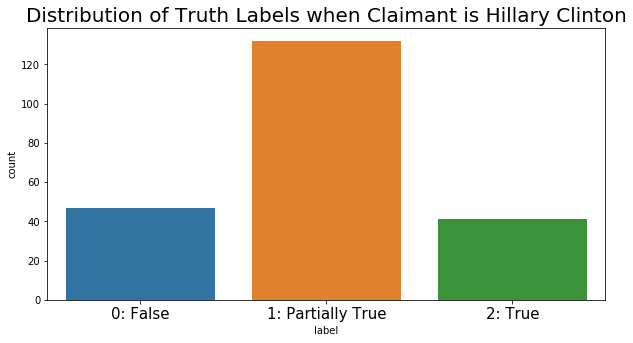

In [33]:
plot_Claimant("Hillary Clinton")

In [34]:
dsn_clinton = get_data_Claimant_OC('Hillary Clinton')
dsn_clinton

,Count,Percentage
1: Partially True,132,0.600000
0: False,47,0.213636
2: True,41,0.186364


### Distribution of truth labels: Viral image

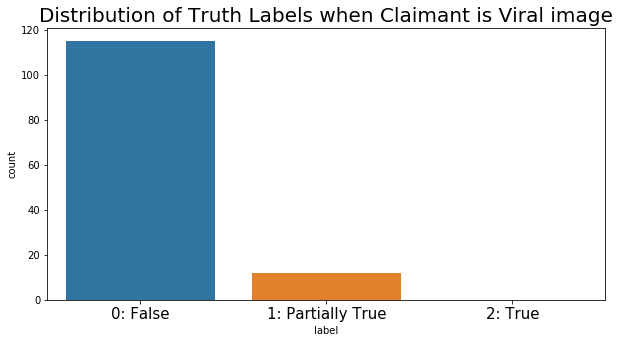

In [35]:
plot_Claimant("Viral image")

In [36]:

g1 = df[df['claimant'] == 'Viral image']['label'].value_counts(normalize=True)
g2 = df[df['claimant'] == 'Viral image']['label'].value_counts()

dsn_viral = pd.DataFrame({'Count': g2, 'Percentage': g1})
dsn_viral.index = ['0: False', '1: Partially True']
dsn_viral

,Count,Percentage
0: False,115,0.905512
1: Partially True,12,0.094488


### Distribution of truth labels: Facebook post

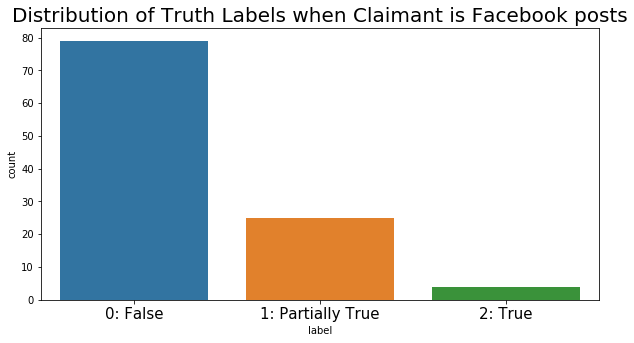

In [37]:
plot_Claimant("Facebook posts")

In [38]:
dsn_facebook = get_data_Claimant('Facebook posts')
dsn_facebook

,Count,Percentage
0: False,79,0.731481
1: Partially True,25,0.231481
2: True,4,0.037037


### Distribution of truth labels: Based on US Election Calendar

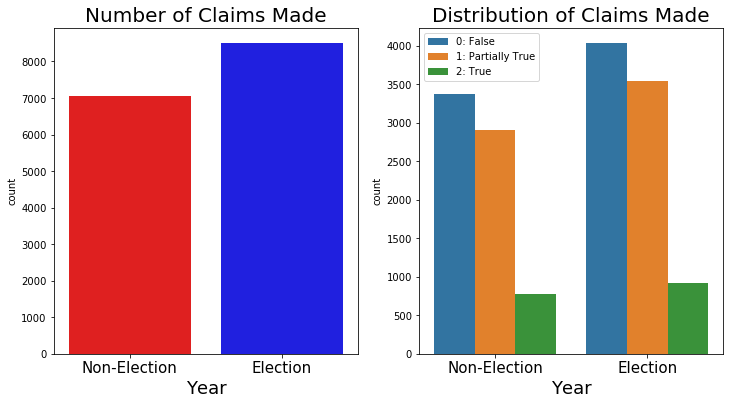

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x='election', data=df, ax=ax1, palette  = ["r","b"])
sns.countplot(x='election',hue = 'label', data=df, ax=ax2)
plt.legend(truth_labels, loc = "best")
ax1.set_title('Number of Claims Made', fontsize = 20)
ax1.set_xlabel("Year", fontsize = 18)
ax1.set_xticklabels(["Non-Election", "Election"], fontsize = 15)
ax2.set_title('Distribution of Claims Made', fontsize = 20)
ax2.set_xlabel("Year", fontsize = 18)
ax2.set_xticklabels(["Non-Election", "Election"], fontsize = 15)
plt.show()

### Number references vs Truth Label

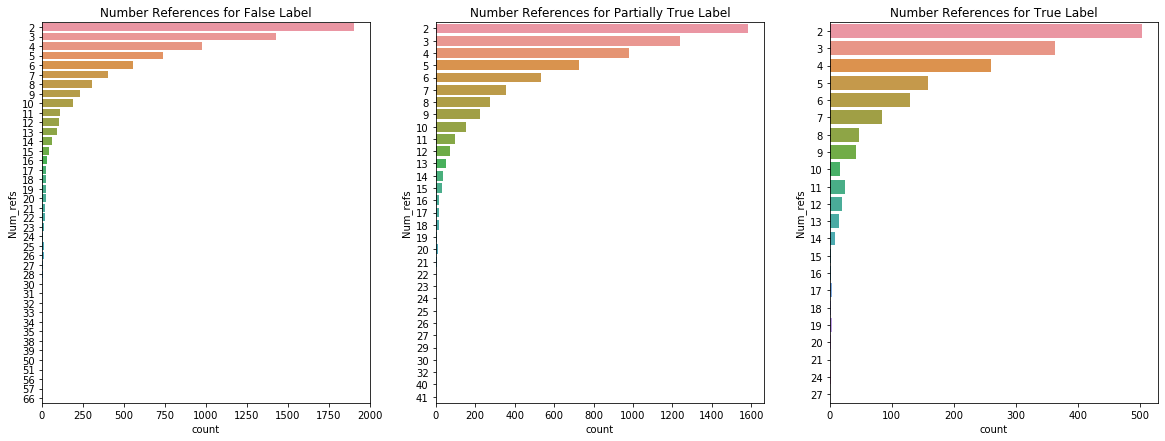

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,7))
sns.countplot(y='Num_refs', data=df[df['label'] == 0], ax=ax1)
ax1.title.set_text('Number References for False Label' )
sns.countplot(y='Num_refs', data=df[df['label'] == 1], ax=ax2)
ax2.title.set_text('Number References for Partially True Label' )
sns.countplot(y='Num_refs', data=df[df['label'] == 2], ax=ax3)
ax3.title.set_text('Number References for True Label' )
plt.show()

In [40]:
import statistics as stat
#average ref for each truth category
Avg_refs_false = sum(df[df['label'] == 0]['Num_refs'])/len(df[df['label'] == 0]['Num_refs'])
Avg_refs_mix = sum(df[df['label'] == 1]['Num_refs'])/len(df[df['label'] == 1]['Num_refs'])
Avg_refs_true = sum(df[df['label'] == 2]['Num_refs'])/len(df[df['label'] == 2]['Num_refs'])

#median ref for each truth category

med_refs_false = stat.median(df[df['label'] == 0]['Num_refs'])
med_refs_mix = stat.median(df[df['label'] == 1]['Num_refs'])
med_refs_true = stat.median(df[df['label'] == 2]['Num_refs'])

print ("False - Average and median: {} references({} references)".format(round(Avg_refs_false,2),round(med_refs_false,2)))
print ("Mixed - Average and median: {} references({} references)".format(round(Avg_refs_mix,2),round(med_refs_mix,2)))
print ("True - Average and median: {} references({} references)".format(round(Avg_refs_true,2),round(med_refs_true,2)))

False - Average and median: 5.26 references(4.0 references)
Mixed - Average and median: 4.84 references(4 references)
True - Average and median: 4.4 references(3.0 references)


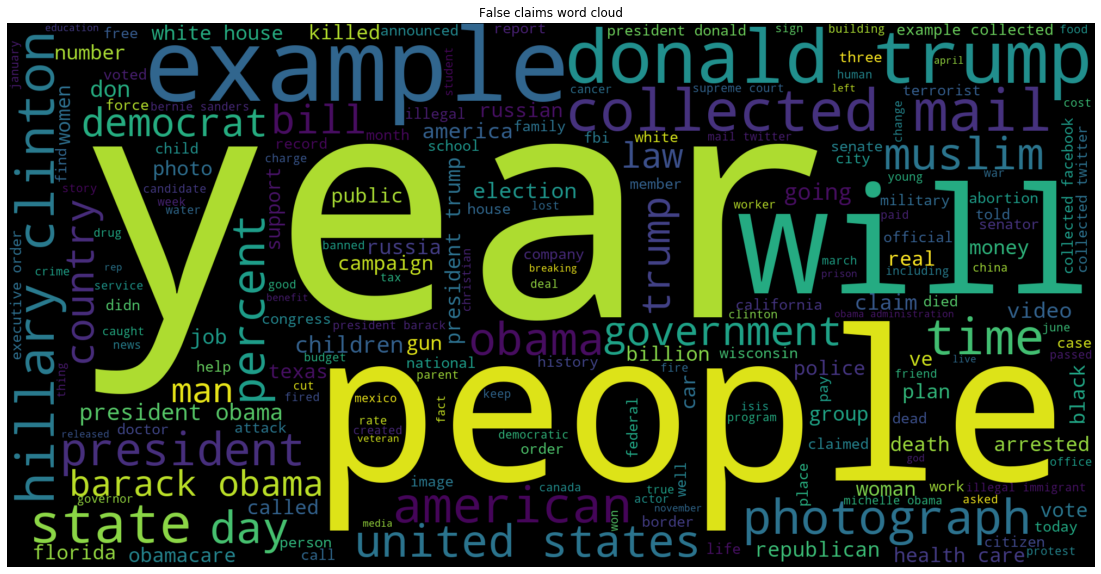

In [41]:
#False claims word cloud
fake_text = " ".join([j for i in df[df['label'] == 0]['cleaned_text'] for j in i.split()])
fake_wordcloud = WordCloud(width = 2000, height = 1000).generate(fake_text)

plt.figure(figsize=(20,10))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('False claims word cloud')
plt.axis("off")
plt.show()

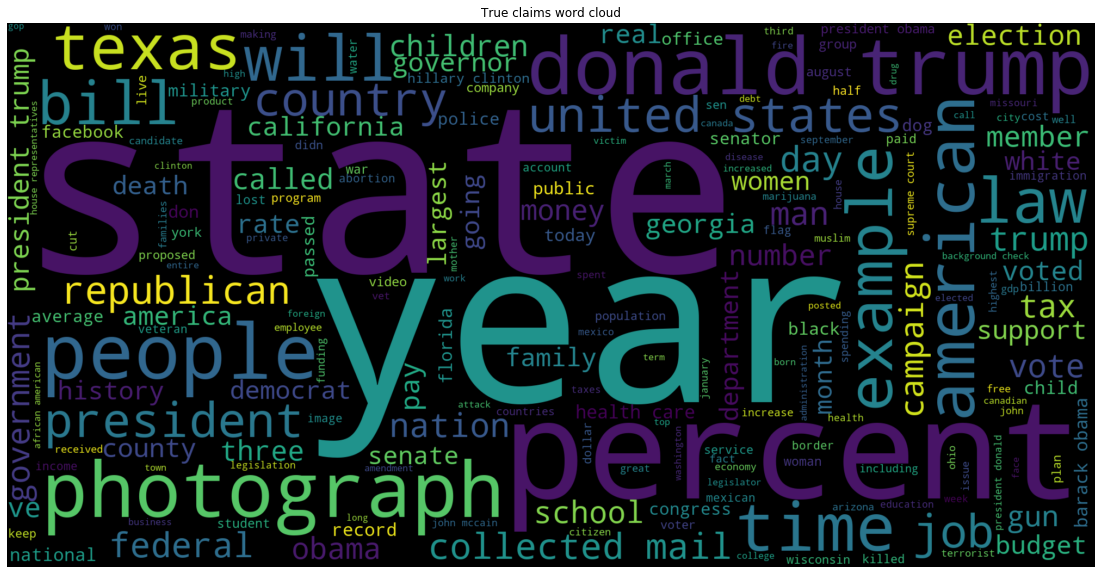

In [42]:
#True claims word cloud
true_text = " ".join([j for i in df[df['label'] == 2]['cleaned_text'] for j in i.split()])
true_wordcloud = WordCloud(width = 2000, height = 1000).generate(true_text)

plt.figure(figsize=(20,10))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title('True claims word cloud')
plt.axis("off")
plt.show()

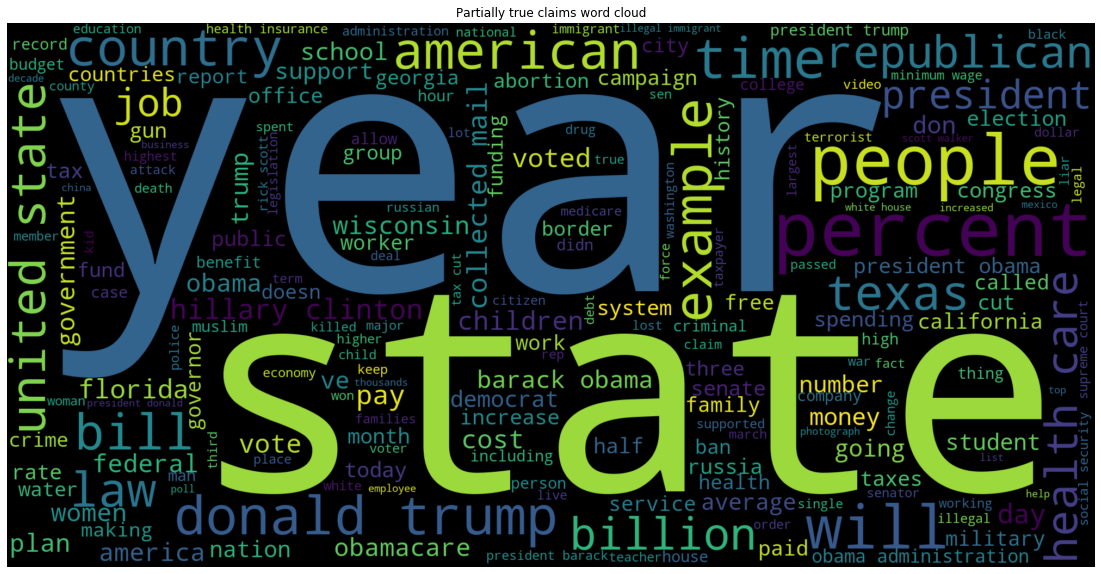

In [43]:
#Partially true claims word cloud
true_text = " ".join([j for i in df[df['label'] == 1]['cleaned_text'] for j in i.split()])
true_wordcloud = WordCloud(width = 2000, height = 1000).generate(true_text)

plt.figure(figsize=(20,10))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title('Partially true claims word cloud')
plt.axis("off")
plt.show()

# Creating a text-based model

For this we will use the powerful fastText library by Facebook.

We need to download the fasttext model and apply it to our data, i.e., associate each word with the corresponding embedding vector. fasttext is a heavy program, so it makes sense to use the C++ library directly. 

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
  
!unzip v0.9.1.zip

--2019-11-29 18:36:12--  https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1 [following]
--2019-11-29 18:36:13--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.1.zip.1’

v0.9.1.zip.1            [    <=>             ]   4.13M  6.43MB/s    in 0.6s    

2019-11-29 18:36:13 (6.43 MB/s) - ‘v0.9.1.zip.1’ saved [4327207]

Archive:  v0.9.1.zip
b5b7d307274ce00ef52198fbc692ed3bd11d9856
replace fastText-0.9.1/.circleci/cmake_test.sh? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Now we need to compile the library. 

In [46]:
%cd fastText-0.9.1

!make

/resources/fastText-0.9.1
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/vector.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/model.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/utils.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/meter.cc
c++ -pthread -std=c++0x -march=native -O3 -f

We need to download the embedding vectors. fasttext is a language-dependent model, so we download the english version. For the four levels of embeddings we select Vectors trained over Wikipedia (1 million words, 16 billion tokens).


In [47]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

!gunzip -v -f cc.en.300.bin.gz


--2019-11-29 03:04:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  15.2MB/s    in 3m 45s  

2019-11-29 03:08:16 (19.1 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

cc.en.300.bin.gz:	 37.8% -- replaced with cc.en.300.bin


# Data Preprocessing

In [52]:
# Keras imports
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, MaxPooling1D, Concatenate, concatenate
from keras.layers import Activation
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc, confusion_matrix

# To visualize models
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

# Estimating the embedding

Now that we have our embedding model, we now complete the following steps:

1. Calculate the words that appear on the text and save to disk
2. Use the fastText program to obtain the word embeddings.
3. Import the embeddings into a Keras input layer.
4. Train the model


In [61]:
%cd ..
df =raw_data_df

/


In [57]:
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(df['cleaned_text']) # Trains it over the tokens that we have.

# Get words
Vals = list(tokenizer.word_index.keys())

# Write CSV with the output.
file = codecs.open('claim.csv', "w", "utf-8")

for item in Vals:
    file.write("%s\r\n" % item)
    
file.close()
!ls

 Canadian_elections_2019.csv
 ET.csv
 GT.csv
'MIE1624H Tutorial 2 - Assignment 1.ipynb'
 NLP_Example_for_Assignment2.ipynb
 Project.ipynb
 claim.csv
 data
 fastText-0.9.1
 generic_tweets.txt
'onaduja_1004613153_assignment2 googlecolab.ipynb'
 onaduja_1004613153_assignment2.ipynb
 stop_words.txt
 train.json
 v0.9.1.zip


Read the first 10 words n the clain csv file

In [58]:
!head claim.csv

trump
president
2016
obama
people
t
example
collected
will
percent


### Obtaining the word embeddings
We do this via calling the fasttext software from the command line.

In [59]:
!./fastText-0.9.1/fasttext print-sentence-vectors fastText-0.9.1/cc.en.300.bin < claim.csv > EmbeddingClaims.tsv

Killed


In [51]:
!head EmbeddingClaims.tsv

-0.0043742 0.018323 -0.010161 0.045189 -0.14469 -0.041543 0.04577 -0.017581 0.0072514 0.012267 0.056059 0.0031095 -0.077107 -0.028628 -0.16092 0.0066247 0.01097 -0.097302 -0.054484 0.03867 0.074459 -0.0035111 -0.088679 0.04193 0.018272 -0.010045 0.031786 -0.00056999 0.010272 0.079384 -0.017983 -0.0050564 -0.0020428 -0.037569 0.062069 -0.03152 -0.013156 0.032391 0.03793 -0.0053947 -0.028153 -0.021673 -0.020323 -0.072576 0.0018486 0.011774 -0.031092 0.027148 0.050691 -0.10681 -0.010863 -0.021861 0.0030492 -0.08187 -0.0063596 -0.024713 0.12893 0.026503 -0.041329 -0.058589 0.033623 0.0031266 -0.09325 -0.0020826 -0.013041 -0.041139 -0.028257 0.086521 -0.068768 -0.15489 0.002872 -0.056089 0.032671 -0.020263 -0.080268 0.089394 0.018968 0.066664 -0.017683 -0.0070563 0.036168 0.042193 0.040286 -0.018679 -0.02065 0.066677 0.0066689 -0.042702 -0.049841 -0.035376 -0.074987 -0.013627 0.071817 0.12115 0.0077899 -0.017228 -0.0319 0.11142 -0.045296 -0.020193 -0.053231 0.027041 0.038878 0.0064566 0.034

Note that this is only for training, for testing we would:

1.   If we keep the embedding as is, we simply calculate the new embeddings for the new words and add it to our matrix.
2.   If we retrained the embeddings, then we would either use the output that we already have if the word was in our original vocabulary, or just leave a vector of zeros for those words if it is not.



In [ ]:
#fastText outputs space-separated words. We replace them with a comma.
import fileinput

with fileinput.FileInput('EmbeddingClaims.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

In [53]:
!head EmbeddingClaims.tsv

-0.0043742,0.018323,-0.010161,0.045189,-0.14469,-0.041543,0.04577,-0.017581,0.0072514,0.012267,0.056059,0.0031095,-0.077107,-0.028628,-0.16092,0.0066247,0.01097,-0.097302,-0.054484,0.03867,0.074459,-0.0035111,-0.088679,0.04193,0.018272,-0.010045,0.031786,-0.00056999,0.010272,0.079384,-0.017983,-0.0050564,-0.0020428,-0.037569,0.062069,-0.03152,-0.013156,0.032391,0.03793,-0.0053947,-0.028153,-0.021673,-0.020323,-0.072576,0.0018486,0.011774,-0.031092,0.027148,0.050691,-0.10681,-0.010863,-0.021861,0.0030492,-0.08187,-0.0063596,-0.024713,0.12893,0.026503,-0.041329,-0.058589,0.033623,0.0031266,-0.09325,-0.0020826,-0.013041,-0.041139,-0.028257,0.086521,-0.068768,-0.15489,0.002872,-0.056089,0.032671,-0.020263,-0.080268,0.089394,0.018968,0.066664,-0.017683,-0.0070563,0.036168,0.042193,0.040286,-0.018679,-0.02065,0.066677,0.0066689,-0.042702,-0.049841,-0.035376,-0.074987,-0.013627,0.071817,0.12115,0.0077899,-0.017228,-0.0319,0.11142,-0.045296,-0.020193,-0.053231,0.027041,0.038878,0.0064566,0.034

### Adding column headings 
We add a first line with the variable names, to be able to import it back.

In [ ]:
# Create the first line
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

# Open as read only. Read the file
with open('EmbeddingClaims.tsv', 'r') as original: 
  data = original.read()

# Open to write and write the first line and the rest
with open('EmbeddingClaims.csv', 'w') as modified: 
  modified.write(firstLine + data)

In [55]:
!head EmbeddingClaims.csv

D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D22

Now we have a matrix with every word in the document with its corresponding Embedding. We can now import this file into Python, and use it to train our model.

# Creating a text embedding

The next step is to actually train a neural network with an Embedding Layer. The following code creates a very simple network that does the following:


1.   Read the embeddings
1.   Calculate the One-Hot inputs (by using an "index") which will index which words are in which text.
1.  Create a layer that associates the indexes with the embeddings.
2.   Create the rest of the architecture.
2.   Train the model.






In [56]:
# Read word embeddings
Embeddings = pd.read_csv('EmbeddingClaims.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)
Embeddings.describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,...,D261,D262,D263,D264,D265,D266,D267,D268,D269,D270,D271,D272,D273,D274,D275,D276,D277,D278,D279,D280,D281,D282,D283,D284,D285,D286,D287,D288,D289,D290,D291,D292,D293,D294,D295,D296,D297,D298,D299,D300
count,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,...,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000
mean,-0.010478,0.000686,-0.003209,0.048091,-0.012915,-0.005276,0.011537,-0.008608,-0.001351,0.007563,-0.010409,0.002759,0.002622,-0.001621,0.001382,-0.008176,-0.006879,0.002364,-0.005588,0.009633,-0.007509,-0.003791,0.006296,0.006962,0.004605,-0.009145,-0.002866,-0.002044,-0.002895,0.099729,-0.006020,-0.000187,0.001217,0.009209,0.001260,0.006042,0.013678,0.020235,-0.002338,0.005232,...,0.001966,-0.007777,-0.011279,0.007616,-0.019079,-0.003095,0.008052,0.000704,-0.003405,0.009795,-0.008833,0.001676,-0.028530,-0.016172,-0.001427,-0.002401,-0.010108,0.010251,-0.020665,-0.005045,0.005780,-0.006903,-0.043889,0.001405,-0.005803,0.007872,-0.003372,0.007102,-0.000775,-0.016375,0.004371,-0.001152,-0.064001,0.022989,0.005939,0.003633,-0.000919,0.065915,0.008301,0.001950
std,0.056020,0.052201,0.056831,0.049960,0.061898,0.062896,0.059035,0.054257,0.054666,0.054612,0.058760,0.059417,0.055880,0.055876,0.056669,0.053689,0.060047,0.057355,0.057824,0.049486,0.054748,0.057211,0.056122,0.054601,0.053117,0.051821,0.054453,0.055415,0.054000,0.069955,0.056255,0.056297,0.055093,0.059008,0.056477,0.053283,0.055251,0.057007,0.052438,0.057056,...,0.056289,0.047535,0.064356,0.055924,0.050622,0.055254,0.056292,0.052105,0.055720,0.052813,0.059356,0.058559,0.049454,0.046187,0.056223,0.050443,0.049372,0.041716,0.048579,0.050517,0.056002,0.054368,0.040124,0.058131,0.054465,0.057220,0.057208,0.068174,0.064875,0.057027,0.057391,0.055537,0.072488,0.058773,0.054336,0.055080,0.053836,0.065413,0.061119,0.058026
min,-0.238420,-0.224540,-0.230060,-0.192970,-0.316260,-0.376930,-0.241330,-0.251950,-0.253600,-0.217080,-0.248430,-0.259920,-0.222790,-0.212440,-0.236690,-0.295840,-0.220950,-0.253360,-0.269360,-0.216770,-0.233520,-0.216220,-0.227680,-0.207160,-0.212720,-0.231870,-0.203350,-0.204940,-0.238730,-0.320580,-0.231150,-0.206510,-0.219110,-0.311030,-0.223820,-0.198840,-0.216890,-0.216930,-0.204430,-0.229720,...,-0.232400,-0.309090,-0.368570,-0.226800,-0.232570,-0.243760,-0.207560,-0.192210,-0.278300,-0.221050,-0.220600,-0.211400,-0.285760,-0.377420,-0.203720,-0.255290,-0.253370,-0.237070,-0.293190,-0.248570,-0.244270,-0.257990,-0.291600,-0.274150,-0.254440,-0.280960,-0.199220,-0.300910,-0.255800,-0.231490,-0.206600,-0.246670,-0.369170,-0.216090,-0.213260,-0.212420,-0.230740,-0.194440,-0.216450,-0.207090
25%,-0.048420,-0.032485,-0.041413,0.019435,-0.052329,-0.045907,-0.026339,-0.044069,-0.037840,-0.028558,-0.050650,-0.035169,-0.033329,-0.038059,-0.036897,-0.037623,-0.047382,-0.035132,-0.043593,-0.022736,-0.043468,-0.042353,-0.031091,-0.029380,-0.028228,-0.044069,-0.039892,-0.039299,-0.0

In [57]:
len(Vals)

20546

We will now create a dictionary for the embeddings. The zip function allows to create the (key, element) structure that we need.

In [ ]:
# Create embedding dictionary

EmbeddingsDict = dict(zip(Vals, Embeddings.values))

Now we want to determine the optimal embedding layer. One of the decisions we need to make is what is going to be the maximum size of our documents. Too large, and we will need to add a lot of padding thus will make it inefficient; too small, and we will be losing a lot of information. There is no clear rule however we will try to cover 90% of all elements. 

Avg. no of words: 12.32
Std. deviation: 17.76
Max words: 730


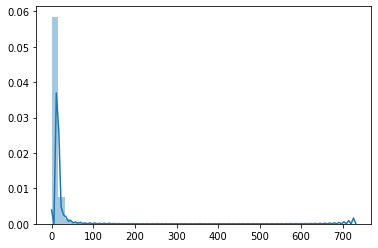

In [59]:
wordDist = [len(w.split()) for w in df['cleaned_text']]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))

# Generate the plot
distClaims = sns.distplot(wordDist)

# I'm saving the image to a PDF, as it makes it easier later to download.
distClaims.figure.savefig("wordDist.pdf", format = "pdf")

Document size of 100 covers more than 90% of our elements

In [60]:
# Create word index from input
sequences = tokenizer.texts_to_sequences(df['cleaned_text']) # Create the sequences.

# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Creates the training dataset, adding padding when necessary. # Apply a limit to 100 words.
data = pad_sequences(sequences, maxlen=100, 
                     padding = 'post') # add padding at the end. 

# Creates the objective function
labels = pd.get_dummies(df['label'])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 20546 unique tokens.
Shape of data tensor: (15555, 100)
Shape of label tensor: (15555, 3)


In [61]:
data[159]

array([2028,   64,  423, 3428,    5,  574, 1744,  840, 1239, 1839,   67,
       1513,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [62]:
labels[2]

0        0
1        1
2        0
3        1
4        1
        ..
15550    1
15551    0
15552    0
15553    1
15554    0
Name: 2, Length: 15555, dtype: uint8

In [63]:
# Create first matrix full with 0's
embedding_matrix = np.zeros((len(word_index) + 1, 300))

# Generate embeddings matrix
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Print what came out
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.0043742,  0.018323 , -0.010161 , ...,  0.016656 ,  0.031481 ,
        -0.027807 ],
       [-0.051514 ,  0.02589  ,  0.0044273, ...,  0.13178  ,  0.16364  ,
         0.0058992],
       ...,
       [ 0.0099687, -0.016106 , -0.014315 , ...,  0.073243 ,  0.091508 ,
        -0.071099 ],
       [ 0.0021108, -0.067133 ,  0.052394 , ...,  0.021968 ,  0.085589 ,
         0.04546  ],
       [-0.051224 , -0.033384 ,  0.12282  , ...,  0.30367  , -0.036898 ,
        -0.046386 ]])

In [64]:
len(embedding_matrix)

20547

Training Model

Our neural net architecture stacks parallel layers as opposed to sequential models. This was explored by [Kim et al. (2014)](https://https://arxiv.org/abs/1408.5882) to create an architecture that uses multiple filters of different lengths, before a final dense layer. The authors argues that this model will have a much better capacity to study complex structures without overfitting. 



## Architecture Plot

The plot of this architecture follows.

![](https://drive.google.com/uc?export=view&id=1W41RmVNWLPHSSm0gR9yEzVPBpyZJ3ym7)

Our architecture now is as follows:

1. An embedding layer.
2. A parallel model of four layers, each consisting of:
    - A Conv1D layer with kernel sizes [2, 3, 4, 6] (arbitrary, selected via grid search), with 200 filters (also also selected via grid search).
    - A max pooling layer of size Embedding Dimension - Filter Size + 1. Basically get just the best feature per filter.
    - A flattening layer to turn this into a vector.
3. A dense layer of size 200.
4. Dropout with probability 0.6.
5. An output layer of size 1.

The authors discuss that this model will have a much better capacity to study complex structures without overfitting.

We start by creating a stacked structure. Given that these go in parallel, we need to create the structure Conv1D - MaxPool - Flattening, and then append them into an object. Finally, the [Concatenate](https://keras.io/layers/merge/#concatenate) layer is the one that puts them in parallel next to each other. 


In [65]:
# Filter sizes to use.
filter_sizes = (2,3,4,6)

# Initialize. We need to give it the input dimension (from the Embedding!)
graph_in = Input(shape=(100, 300))
convs = []
avgs = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=200,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
    conv = Dropout(0.6)(conv)
    pool = MaxPooling1D(pool_size=100 - fsz + 1)(conv) # Put this layer AFTER the convolution just created. Size set to 100 from 36
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "graphModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 200)      120200      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 98, 200)      180200      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 97, 200)      240200      inp

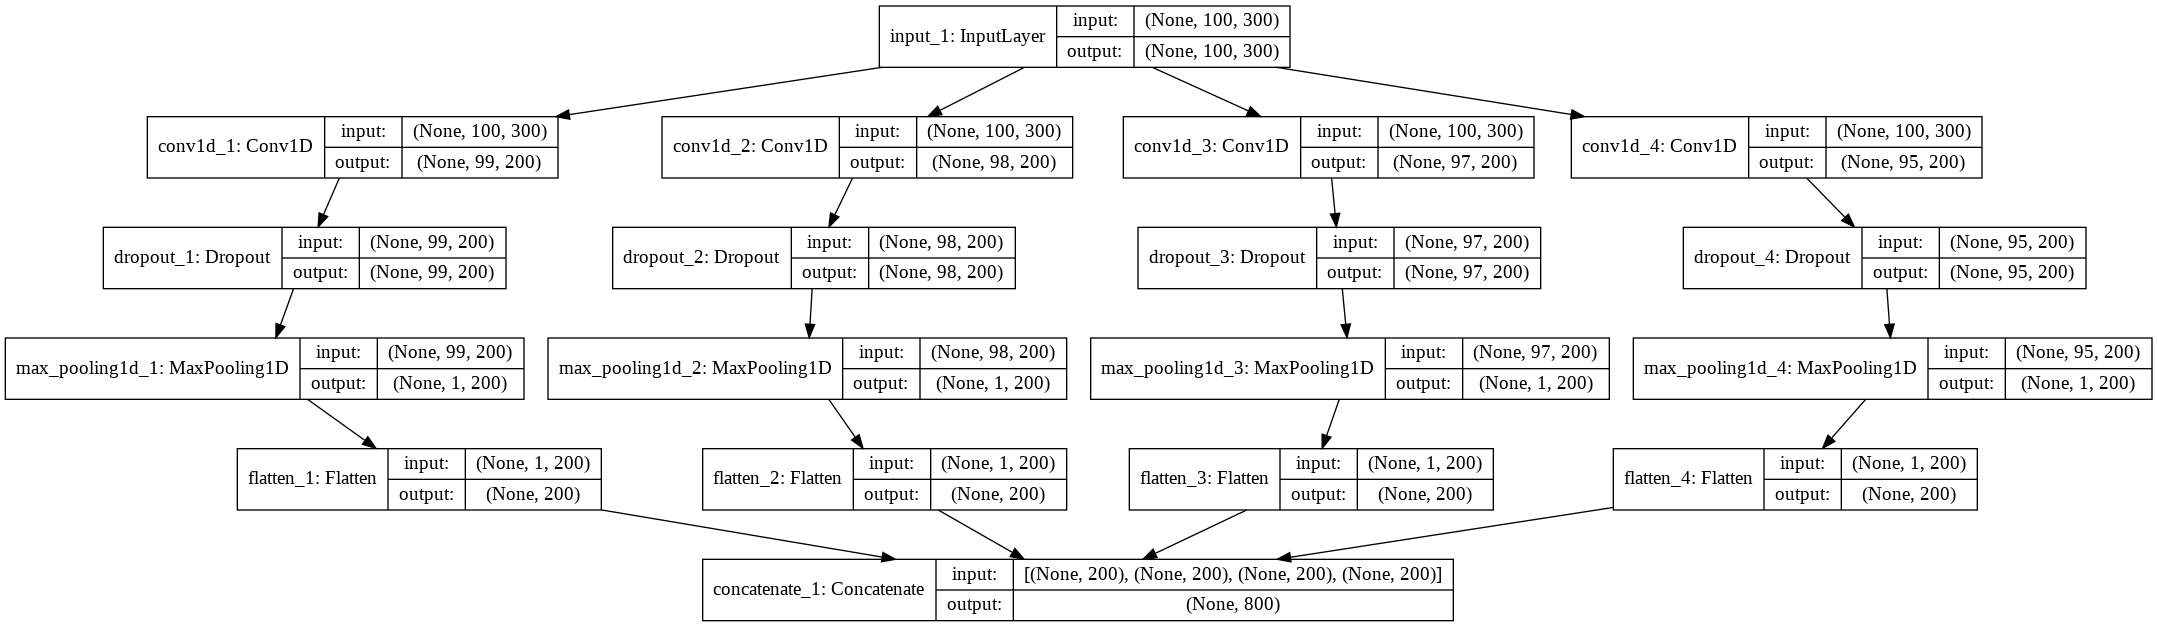

In [66]:
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(graph, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

The above is the "middle" part of the network, so we need to add:
* an input layer, and 
* an output layer.


In [67]:
# Final model
model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=100,              # The maximum number of words = 100.
                            trainable=False)               # To NOT recalculate weights!

model.add(embedding_layer)

# Now we add our graph model
model.add(graph)

# Add a few layers
model.add(Dense(200, activation='relu')) #Rectified Linear Unit.
model.add(Dropout(0.4))
model.add(Dense(3, activation='sigmoid')) #Sigmoid activation function.

In [68]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          6164100   
_________________________________________________________________
graphModel (Model)           (None, 800)               900800    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               160200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 7,225,703
Trainable params: 1,061,603
Non-trainable params: 6,164,100
_________________________________________________________________


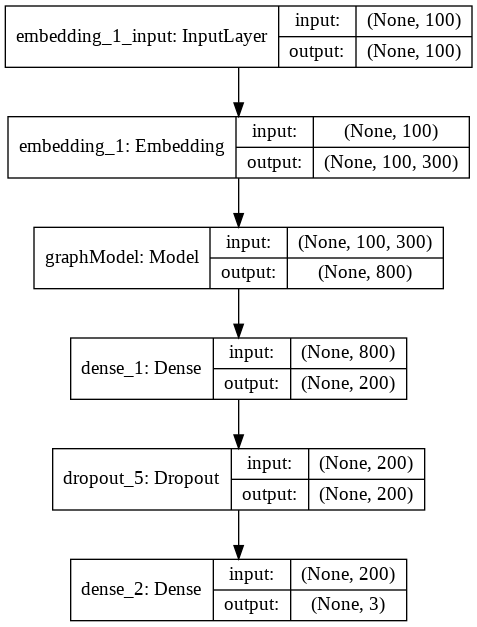

In [70]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

The summary shows the graph model one more layer of our main sequential model. 

Now we can simply train our neural network, splitting into train and test datasets.


In [ ]:
from sklearn.utils import class_weight
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33,
                                                    random_state=20190925, 
                                                    stratify = labels)


In [ ]:
y_train_w1 = pd.DataFrame(data = y_train, columns = [0, 1, 2])
y_train_w2 = y_train_w1.idxmax(axis = 1)

# Define Class weights for balance
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_w2), y_train_w2)
class_weights = dict(enumerate(weights))


In [86]:
class_weights

{0: 0.6999126872187521, 1: 0.8037174147771093, 2: 3.057805164319249}

In [87]:
model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=20,
          class_weight = class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6982 samples, validate on 3439 samples
Epoch 1/100
6982/6982 [==============================] - 14s 2ms/step - loss: 1.0673 - acc: 0.4857 - val_loss: 1.0553 - val_acc: 0.4554
Epoch 2/100
6982/6982 [==============================] - 9s 1ms/step - loss: 1.0201 - acc: 0.5149 - val_loss: 1.0404 - val_acc: 0.4286
Epoch 3/100
6982/6982 [==============================] - 9s 1ms/step - loss: 0.9509 - acc: 0.5584 - val_loss: 1.0434 - val_acc: 0.5100
Epoch 4/100
6982/6982 [==============================] - 9s 1ms/step - loss: 0.8449 - acc: 0.5977 - val_loss: 1.0413 - val_acc: 0.5065
Epoch 5/100
6982/6982 [==============================] - 9s 1ms/step - loss: 0.6780 - acc: 0.6779 - val_loss: 1.2361 - val_acc: 0.5403
Epoch 6/100
6982/6982 [==============================] - 9s 1ms/step - loss: 0.5376 - acc: 0.7578 - val_loss: 1.1725 - val_acc: 0.5156
Epoch 7/100
6982/6982 [======================

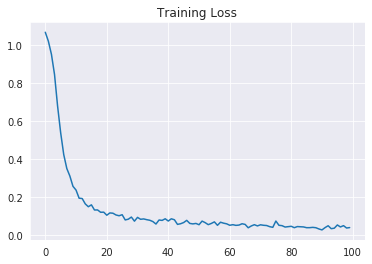

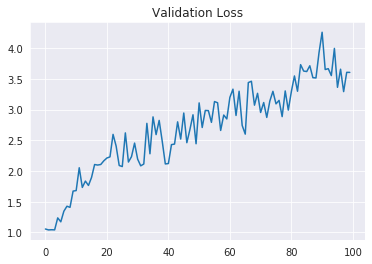

In [88]:
# Plot history
sns.set_style("darkgrid")
plt.plot(model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

## Confusion Matrix

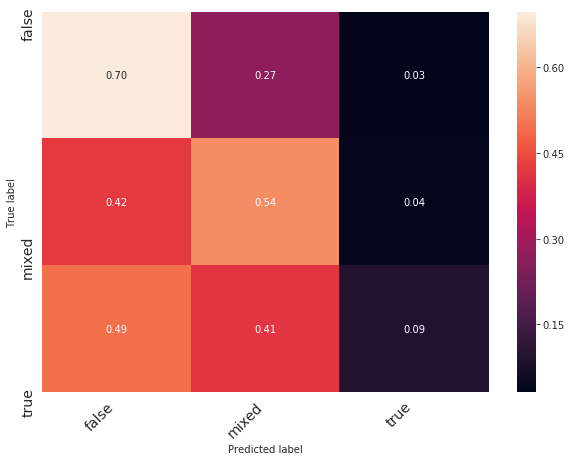

In [97]:
# Calculate outputs in test set
prob_test = np.round(model.predict(X_test))
prob_test2 = pd.DataFrame(data = prob_test, columns = [0, 1, 2])
prob_test3 = prob_test2.idxmax(axis = 1)
#prob_test3

y_test_label = y_test.idxmax(axis = 1)
#y_test_label

# Calculate confusion matrix
confusion_matrix_dnn_sim = confusion_matrix(y_true = y_test_label, y_pred = prob_test3)
#confusion_matrix_dnn_sim

# Turn matrix to percentages
confusion_matrix_dnn = confusion_matrix_dnn_sim.astype('float') / confusion_matrix_dnn_sim.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_dnn, index=['false', 'mixed', 'true'],
         columns=['false', 'mixed', 'true'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

pos =[0,1.8,3]
plt.yticks(pos,rotation= 'vertical')
plt.show()


### Recall, Precision, and F1-Score
We can view this metrics by running a classification_report on the results of the model.

These metrics are more on a per-class basis. 

* Precision: Precision is the ability of a classifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. 

* Recall: Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. 

* The F1 score: is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

* Support: is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

The weighted average F1 score for our fitted model is shown below.


In [98]:
#Accuracy
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test_label,prob_test3))

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      2445
           1       0.56      0.54      0.55      2129
           2       0.24      0.09      0.13       560

    accuracy                           0.57      5134
   macro avg       0.46      0.44      0.44      5134
weighted avg       0.54      0.57      0.55      5134



In [99]:
print(accuracy_score(y_test_label,prob_test3))

0.5650564861706272


In [ ]:
keras.backend.clear_session()

In [ ]:
K.clear_session()

In [ ]:
del model#Multi_Model

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

##Multimodal Learning Model
We have number of additional variables, outside of the claim text that we can use can use to determine the truthfulness of each claim:
claimant, Number of references (Num_refs which is the sum of the related articles), year (the year that the claim was made. Our case we divided the claims into claims made in election years and claims made in non-election years based on the US presidential and congressional election calendar).

Hence, we have a number of categorical variable categorical variables, a numerical variable and a text variable. Thus, three different data channels can be used to estimate this model. We will implement the following data architecture:
1.	For the categorical variables, generate a categorical embedding which reduces the number of categories. We will train the embedding such that it considers interactions between categories.
2.	For the text variable, use an embedding to generate a text model, and then generate a series of high-level features using a Kim et al. (2005) architecture.
3.	Input the numerical variable as another feature for the final dataset.
4.	Combine everything with a few dense layers to preprocess the dataset.
We will compare the text-only model with the categorical model in a subset of the data.

In [103]:
raw_data_df.head()

,claim,claimant,date,label,related_articles,id,cleaned_text,Num_refs,year,election
0,A line from George Orwell's novel 1984 predict...,Unknown,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,george orwell novel 1984 predicts power smartp...,4,2017,False
1,Maine legislature candidate Leslie Gibson insu...,Unknown,2018-03-17,2,"[106868, 127320, 128060]",1,maine legislature candidate leslie gibson insu...,3,2018,True
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,2018-07-18,1,"[132130, 132132, 149722]",4,17 year girl named alyssa carson trained nasa ...,3,2018,True
3,In 1988 author Roald Dahl penned an open lette...,Unknown,2019-02-04,2,"[123254, 123418, 127464]",5,1988 author roald dahl penned open letter urgi...,3,2019,False
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,fighting terrorism thing work based lots empir...,6,2016,True


In [104]:
# Create dummies from the categorical variables
raw_df_Dummies = raw_data_df.iloc[:, np.r_[1,9]]

# Encode them as numeric
from sklearn import preprocessing

le_claimant = preprocessing.LabelEncoder()
le_claimant.fit(raw_df_Dummies.iloc[:, 0])
raw_df_Dummies['claimant'] = le_claimant.transform(raw_df_Dummies.iloc[:, 0])

le_num_election = preprocessing.LabelEncoder()
le_num_election.fit(raw_df_Dummies.iloc[:, 1])
raw_df_Dummies['election'] = le_num_election.transform(raw_df_Dummies.iloc[:, 1])

raw_df_Dummies.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,claimant,election
count,15555.000000,15555.000000
mean,1910.795436,0.546448
std,1013.245077,0.497854
min,0.000000,0.000000
25%,811.500000,0.000000
50%,2187.000000,1.000000
75%,2923.000000,1.000000
max,3103.000000,1.000000


In [105]:
raw_df_Dummies.head(20)

,claimant,election
0,2923,0
1,2923,1
2,2923,1
3,2923,0
4,1121,1
5,1650,1
6,1327,1
7,2923,0
8,2385,0
9,2001,0


In [106]:
raw_df_Dummies.nunique()

claimant    3104
election       2
dtype: int64

We have 3147 dummy columns which we would like to turn into an embedding. The process is the same as the embedding before, we just create a model with those inputs and outputs using the model API.

We use 200 dimensions for the embedding. This is a free parameter that we must determine. Experimentally, this number should be between  [√‾‾𝐼,𝐼/2] , where  𝐼  is the number of dummy variables in the input.

We now just need the numerical model to add the lonely numerical variable.

In [ ]:
# Generate the input
Input_cat = Input(shape=(2, ))

# Generate the embedding
embedding_layer_cat = Embedding(input_dim = 3106 + 1,        # Input size
                                output_dim = 50,           # Embedding dimensions
                                input_length=2,            # Variables.
                                trainable=True)(Input_cat) # Allow weight training.

# Flatten the embedding to make it a proper layer.
embedding_layer_cat = Flatten()(embedding_layer_cat)

In [ ]:
num_in = Input(shape=(1,), name='numerical_input')

We now re-create our text model, but without the dense layers.

In [109]:
# Filter sizes to use.
filter_sizes = (2,3,4,6)

# Initialize. We need to give it the input dimension (from the Embedding!)
graph_in = Input(shape=(100, ))
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=100,              # The maximum number of words.
                            trainable=False)(graph_in)               # To NOT recalculate weights!
convs = []
avgs = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=200,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(embedding_layer) # Note the (embedding_layer). This means "put this layer AFTER the graph_in layer.
    conv = Dropout(0.6)(conv)
    pool = MaxPooling1D(pool_size=100 - fsz + 1)(conv) # Put this layer AFTER the convolution just created.
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()

Model: "graphModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     6164100     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 200)      120200      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 98, 200)      180200      embedding_2[0][0]                
_________________________________________________________________________________________

We will now use the functional API to merge all of these models using a Concatenate layer.

In [ ]:
x = concatenate([num_in, embedding_layer_cat, out])

And finally we add a few dense layers with Dropout

In [ ]:
# Dense layers
x = Dense(200, activation= 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(200, activation= 'relu')(x)
x = Dropout(0.4)(x)

# Output layer
out_combined = Dense(3, activation = 'softmax')(x)

And to finish we create and inspect the combined model.

In [ ]:
Multi_Model = Model(inputs = [graph_in, num_in, Input_cat], outputs = out_combined)

# adam = Adam(clipnorm=.1)
Multi_Model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

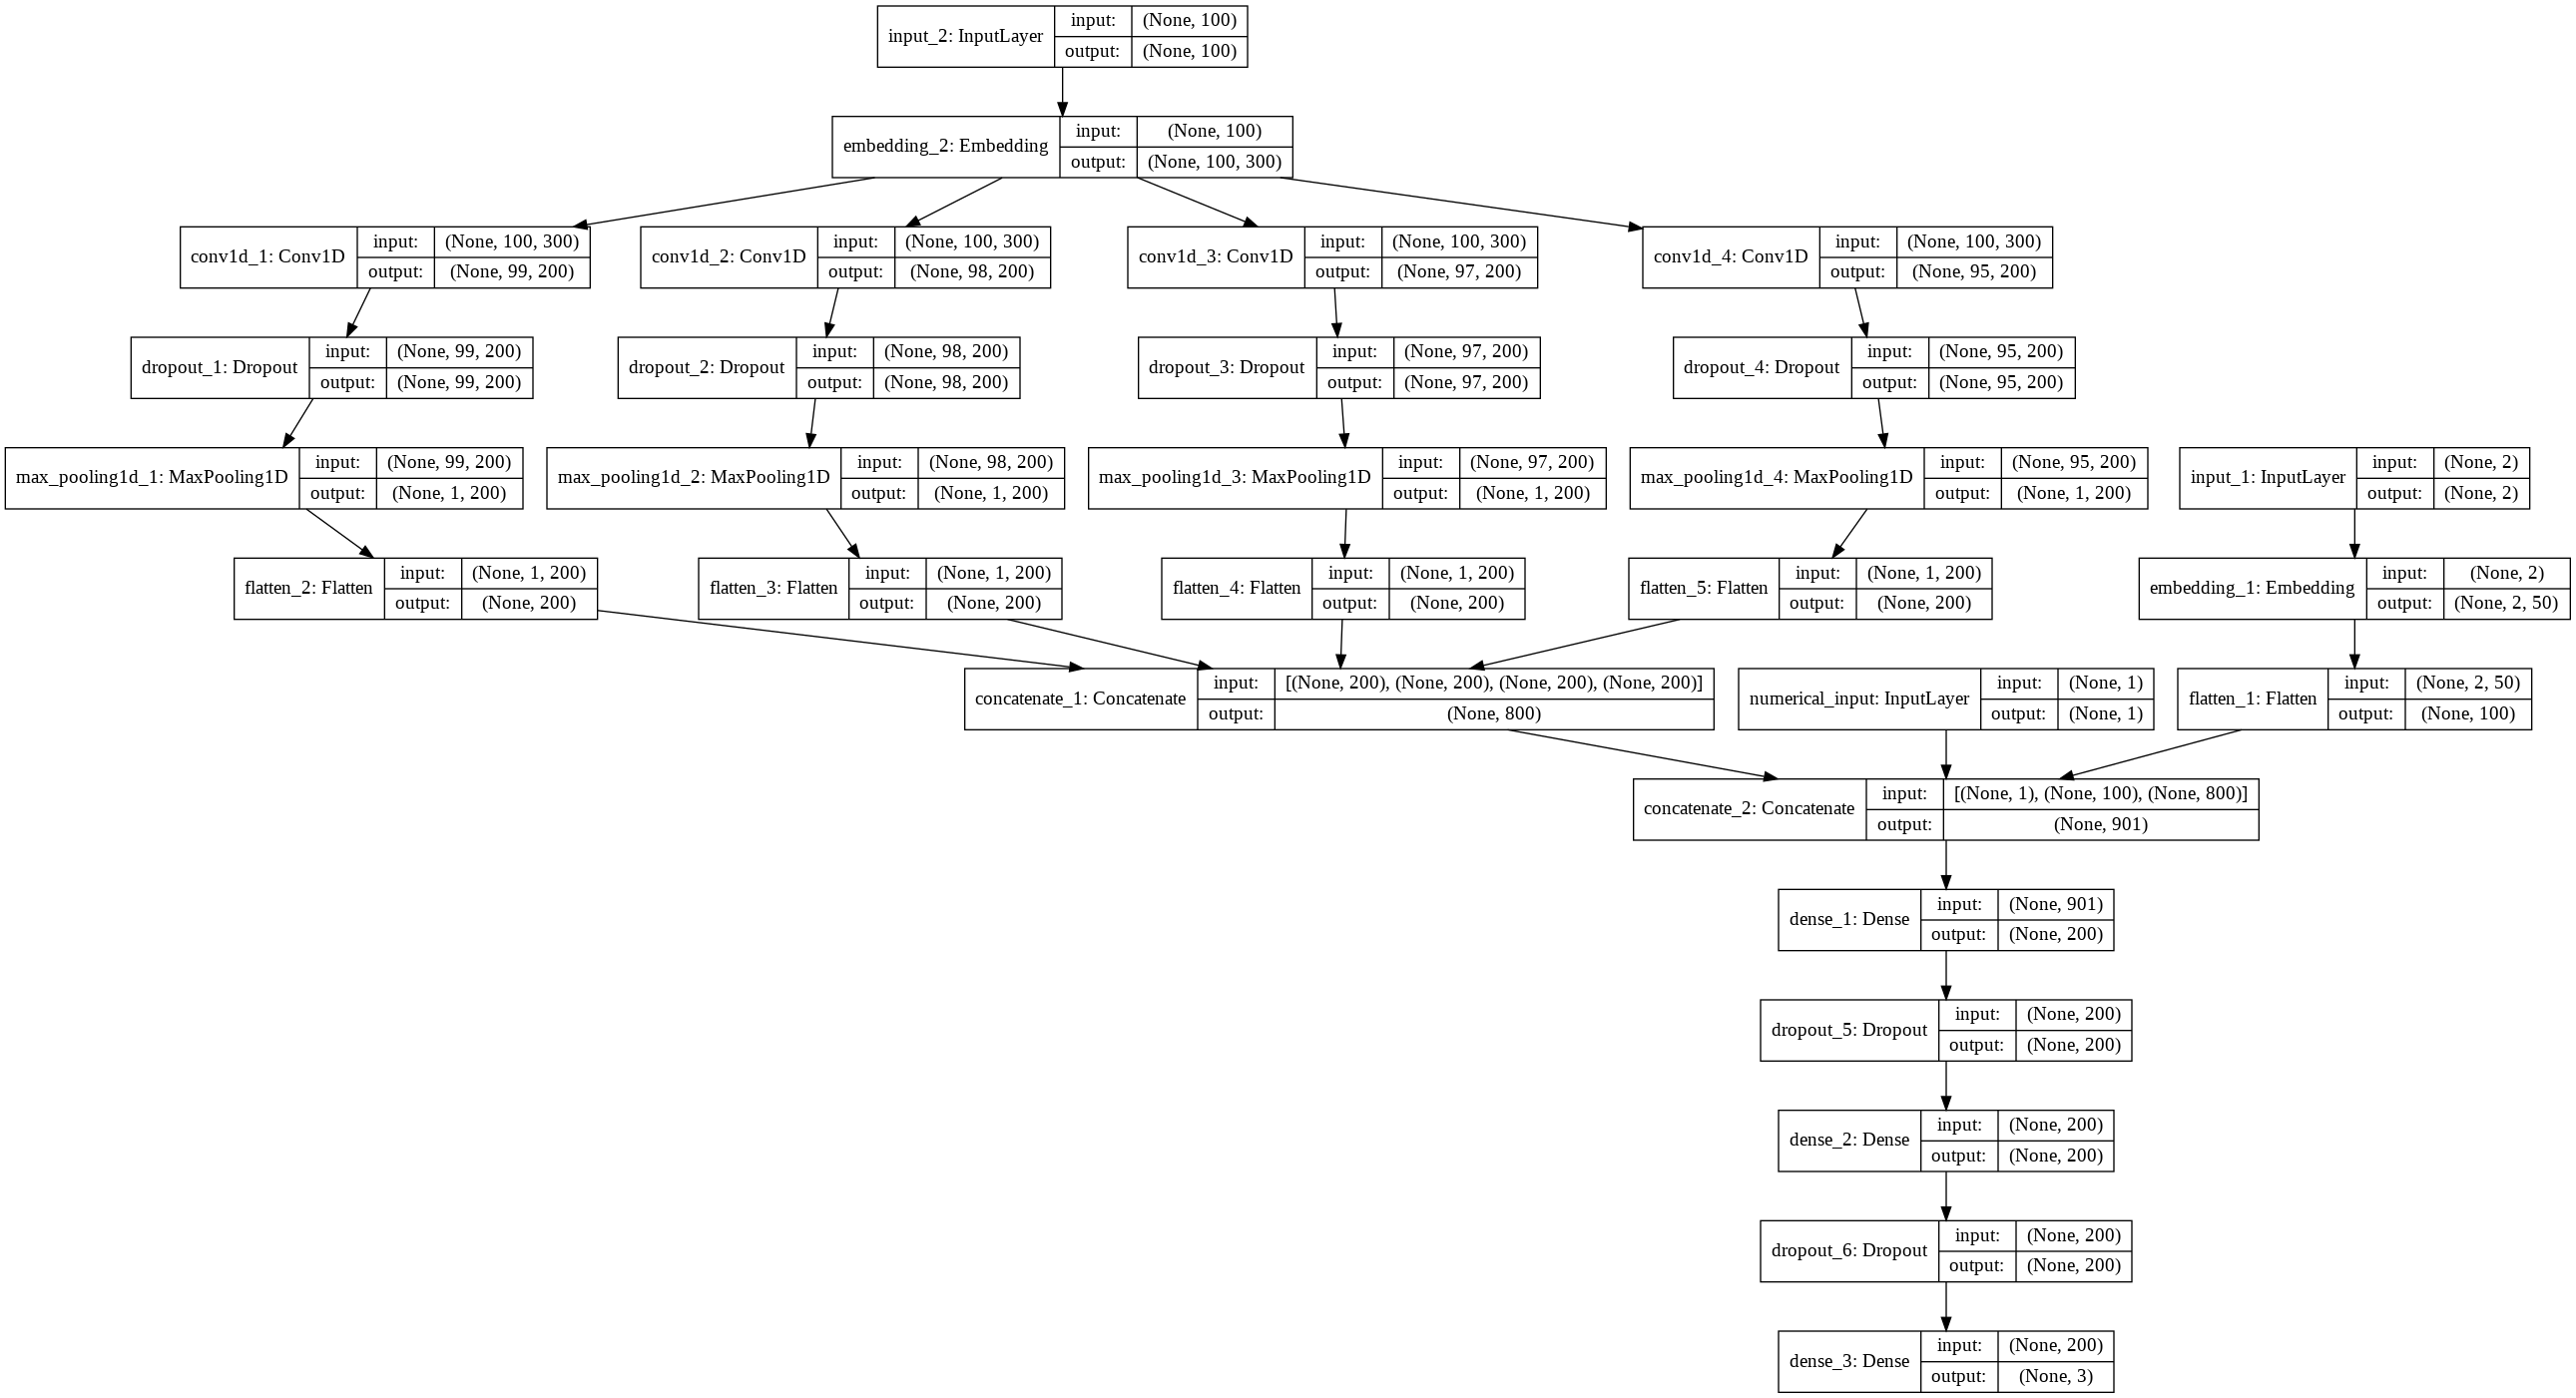

In [113]:
plot_model(Multi_Model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [114]:
Multi_Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     6164100     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 200)      120200      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 98, 200)      180200      embedding_2[0][0]                
____________________________________________________________________________________________

### Train the model
 To train the model we need to provide the inputs in the order they were specified in the model definition. We will also create a train and test set for these dataset. 

In [ ]:
multi_data = np.concatenate((np.expand_dims(raw_data_df['Num_refs'], axis=1),
                             raw_df_Dummies, data), axis = 1)

X_train, X_test, y_train, y_test = train_test_split(multi_data, labels, test_size=0.33,
                                                    random_state=20190925, 
                                                    stratify = labels)

# 0: Numerical, 1:3 -> Dummies, 3:153 -> Categorical

In [116]:
multi_data.shape

(15555, 103)

In [117]:
Multi_Model.fit([X_train[:, 3:103], X_train[:, 0], X_train[:, 1:3], ], y = y_train,
                validation_split = 0.33, class_weight = class_weights,
                epochs = 100, batch_size = 20)

Train on 6982 samples, validate on 3439 samples
Epoch 1/100
6982/6982 [==============================] - 11s 2ms/step - loss: 1.0930 - acc: 0.4368 - val_loss: 1.0595 - val_acc: 0.5766
Epoch 2/100
6982/6982 [==============================] - 10s 1ms/step - loss: 1.0045 - acc: 0.5248 - val_loss: 0.9900 - val_acc: 0.4106
Epoch 3/100
6982/6982 [==============================] - 10s 1ms/step - loss: 0.9065 - acc: 0.5981 - val_loss: 0.9857 - val_acc: 0.4975
Epoch 4/100
6982/6982 [==============================] - 10s 1ms/step - loss: 0.7707 - acc: 0.6611 - val_loss: 1.0317 - val_acc: 0.4591
Epoch 5/100
6982/6982 [==============================] - 10s 1ms/step - loss: 0.6128 - acc: 0.7307 - val_loss: 1.1757 - val_acc: 0.5656
Epoch 6/100
6982/6982 [==============================] - 10s 1ms/step - loss: 0.4653 - acc: 0.7919 - val_loss: 1.3761 - val_acc: 0.5711
Epoch 7/100
6982/6982 [==============================] - 10s 1ms/step - loss: 0.3922 - acc: 0.8253 - val_loss: 1.4839 - val_acc: 0.5231


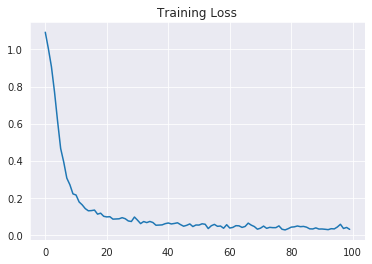

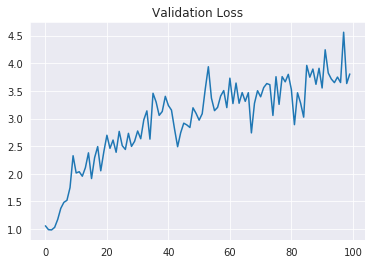

In [118]:
# Plot history
sns.set_style("darkgrid")
plt.plot(Multi_Model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(Multi_Model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

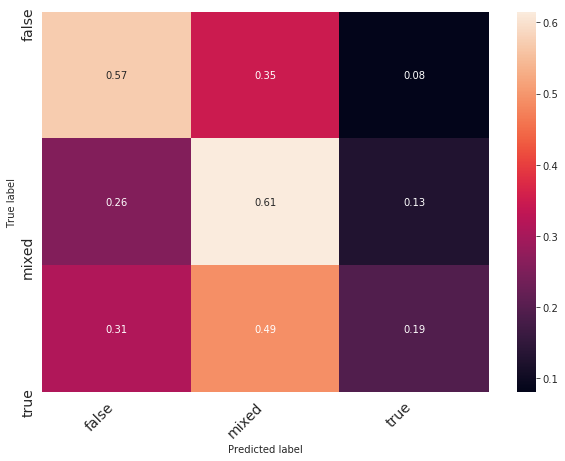

In [120]:
# Calculate outputs in test set
prob_test = np.round(Multi_Model.predict([X_test[:, 3:203], X_test[:, 0], X_test[:, 1:3]]))
prob_test = pd.DataFrame(data = prob_test, columns = [0, 1, 2])
prob_test = prob_test.idxmax(axis = 1)

y_test_label = y_test.idxmax(axis = 1)

# Calculate confusion matrix
confusion_matrix_dnn = confusion_matrix(y_true = y_test_label, 
                    y_pred = prob_test)

# Turn matrix to percentages
confusion_matrix_dnn = confusion_matrix_dnn.astype('float') / confusion_matrix_dnn.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_dnn, index=['false', 'mixed', 'true'],
         columns=['false', 'mixed', 'true'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

pos =[0,1.8,3]
plt.yticks(pos,rotation= 'vertical')
plt.show()

# Plot!
plt.show()



In [121]:
#Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(classification_report(y_test_label,prob_test))

              precision    recall  f1-score   support

           0       0.66      0.57      0.61      2445
           1       0.54      0.61      0.57      2129
           2       0.19      0.19      0.19       560

    accuracy                           0.55      5134
   macro avg       0.46      0.46      0.46      5134
weighted avg       0.56      0.55      0.55      5134



In [152]:
print(accuracy_score(y_test_label,prob_test))

0.5479158550837554


# Logistic Regression
Here we run a simple logistic regression algorithm classifier to compare our results from the more sophisticated convolutional neural network models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.33,
                                                    random_state=20190925, 
                                                    stratify = labels)

In [158]:
from sklearn.linear_model import LogisticRegression

Logistic_classifier = LogisticRegression(solver= 'sag', max_iter=10000, multi_class= 'ovr')
Logistic_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Logsitic_predictions = Logistic_classifier.predict(X_test)

In [160]:
print(classification_report(y_test,Logsitic_predictions))

              precision    recall  f1-score   support

           0       0.48      0.90      0.63      2445
           1       0.45      0.11      0.17      2129
           2       0.00      0.00      0.00       560

    accuracy                           0.48      5134
   macro avg       0.31      0.34      0.27      5134
weighted avg       0.41      0.48      0.37      5134



In [161]:
print(accuracy_score(y_test,Logsitic_predictions))

0.47506817296455006


# Grid Search for our best model
The first CNN which model the text only features perfromed the best. We will now do a grid search to hypertune the paramaters of our neural network. We will hypertune the following parameters:

*   Filters
*   Drop-out rates
*   Weights
*   Activation Function



In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33,
                                                    random_state=20190925, 
                                                    stratify = labels)
#Calculating input weights for our NN
y_train_w1 = pd.DataFrame(data = y_train, columns = [0, 1, 2])
y_train_w2 = y_train_w1.idxmax(axis = 1)

#Weights
weights_balanced = class_weight.compute_class_weight('balanced', np.unique(y_train_w2), y_train_w2)
class_weights_balanced = dict(enumerate(weights_balanced))


In [ ]:
def Ibrahim_Ayo_Kev(dropout_rate1=0.0, dropout_rate2 =0.0, filt1 = 50, filt2= 50, act1 = 'relu',act2 = 'relu', act3 = 'sigmoid'):
  filter_sizes = (2,3,4,6)

  # Initialize. We need to give it the input dimension (from the Embedding!)  
  graph_in = Input(shape=(100, 300))
  convs = []
  avgs = []

  # This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
  # that to the "conv" variable, which is simply a stack of convolutions.
  for fsz in filter_sizes:
    conv = Conv1D(filters=filt1,
                    kernel_size=fsz,
                           padding='valid',
                           activation=act1,
                           strides=1)(graph_in) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
    conv = Dropout(dropout_rate1)(conv)
    pool = MaxPooling1D(pool_size=100 - fsz + 1)(conv) # Put this layer AFTER the convolution just created. Size set to 100 from 36
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
  # Concatenate layers.
  if len(filter_sizes)>1:
    out = Concatenate()(convs)
  else:
    out = convs[0]

  graph = Model(inputs=graph_in, outputs=out, name="graphModel")

  # Final model
  model = Sequential()
  embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                              300,                           # Embedding dimension
                              weights=[embedding_matrix],    # The weights we just calculated
                              input_length=100,              # The maximum number of words = 100.
                              trainable=False)               # To NOT recalculate weights!

  model.add(embedding_layer)

  # Now we add our graph model
  model.add(graph)

  # Add a few layers
  model.add(Dense(filt2, activation=act2)) #Rectified Linear Unit.
  model.add(Dropout(dropout_rate2))
  model.add(Dense(3, activation=act3)) #Sigmoid activation function.
  
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

  return model


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                    random_state=20190925, 
                                                    stratify = labels)

In [ ]:
model = KerasClassifier(build_fn=Ibrahim_Ayo_Kev, verbose=0)
# define the grid search parameters
dropout_rate1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout_rate2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
filt1 = [50, 100, 150, 200, 250, 300]
filt2 = [50, 100, 150, 200, 250, 300]
act1 = ['relu', 'tanh', 'sigmoid', 'softmax', 'linear']
act2 = ['relu', 'tanh', 'sigmoid', 'softmax', 'linear']
act3 = ['sigmoid', 'tanh', 'relu', 'softmax', 'linear']
epochs = [20]
batch_size = [20]
class_weights= [class_weights_balanced]

param_grid = dict(dropout_rate1=dropout_rate1, dropout_rate2=dropout_rate1, filt1=filt1, filt2=filt2, act1=act1, act2=act2, act3=act3, batch_size=batch_size, epochs=epochs, class_weight = class_weights)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
